In [1]:
import astropy
import astropy.units as u
import astroquery
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.time import Time 
import os
from astropy.io.votable import parse_single_table
from astropy.time import Time
import pytest
from astropy.table import Table, vstack
import csv
import pandas as pd

%matplotlib inline

In [2]:
# First write a script to make such a plot for a single pulsar, choose a fun one :)
# PSR J0437-4715

# define necessary variables as strings 
ra = Angle('04:37:15.8961737', unit = u.hourangle)
dec = Angle('-47:15:09.110714', unit = u.deg)

pmra = u.Quantity('+121.4385', u.mas/u.yr)
pmdec = u.Quantity('-71.4754', u.mas/u.yr)

posepoch = Time(54500.00, format='mjd').jyear

psr = SkyCoord(ra= '04:37:15.8961737', dec= '-47:15:09.110714', unit= (u.hourangle, u.deg), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)

# ok now we have to deal with the errors on pos and pm: instantiate them as angle objects of the proper 
# representation, for both the pos and pm errors
ra_err_str = '6.0e-07'
if 'e' in ra_err_str:
    base, exp = ra_err_str.split('e')
    base = float(base)
    exp = float(exp)
    num = base*(10**exp)
    ra_err = Angle(num, unit = u.hourangle)
else:
    num = float(ra_err_str)
    ra_err = Angle(num, unit = u.hourangle)


dec_err_str = '7.0e-06'
if 'e' in dec_err_str:
    base, exp = dec_err_str.split('e')
    base = float(base)
    exp = float(exp)
    num = base*(10**exp)
    dec_err = Angle(num, unit = u.deg)
else:
    num = float(dec_err_str)
    dec_err = Angle(num, unit = u.deg)

pmra_err_str = '2.0e-03'
if 'e' in pmra_err_str:
    base, exp = pmra_err_str.split('e')
    base = float(base)
    exp = float(exp)
    num = base*(10**exp)
    pmra_err = Angle(num, unit = u.mas)  / u.yr
else:
    num = float(pmra_err_str)
    pmra_err = Angle(num, unit = u.mas)  / u.yr

pmdec_err_str = '2.0e-03'
if 'e' in pmdec_err_str:
    base, exp = pmdec_err_str.split('e')
    base = float(base)
    exp = float(exp)
    num = base*(10**exp)
    pmdec_err = Angle(num, unit = u.mas) /u.yr
else:
    num = float(pmdec_err_str)
    pmdec_err = Angle(num, unit = u.mas) / u.yr

plotting_pmdec = psr.pm_dec.to_value(u.deg/u.yr) 
plotting_pmra = psr.pm_ra_cosdec.to_value(u.deg/u.yr) 
plotting_ra = psr.ra.value
plotting_dec = psr.dec.value

Define necessary quantities to perform translation, add errors in quadrature

In [3]:
# let's make sure we're able simply to propogate the error on (ra and pmra) and (dec and pmdec)
# it's important to choose one unit and stick to it: here we have already implemented mas

dr2epoch = Time('2015.5', format='jyear').jyear
dr3epoch = Time('2016.0', format='jyear').jyear
epoch_diff_dr2 = (dr2epoch.tolist() * u.yr) - (posepoch.tolist() * u.yr)
epoch_diff_dr3 = (dr3epoch.tolist() * u.yr) - (posepoch.tolist() * u.yr)

# define our new vector of pm times the time diff
# dr2 
prop2ra = psr.pm_ra_cosdec * epoch_diff_dr2
prop2dec = psr.pm_dec * epoch_diff_dr2
# dr3
prop3ra = psr.pm_ra_cosdec * epoch_diff_dr3
prop3dec = psr.pm_dec * epoch_diff_dr3


prop_ra_dr2 = psr.ra.mas * u.mas + (prop2ra)
prop_dec_dr2 = psr.dec.mas * u.mas + (prop2dec)

prop_ra_dr3 = psr.ra.to_value(u.mas) * u.mas + (prop3ra) # adds to the position the distance traversed between epochs from the pmra 
prop_dec_dr3 = psr.dec.to_value(u.mas) * u.mas + (prop3dec)

# error propagated with poserr + (pmerr * time), and added in quadrature
prop_ra_err_dr2 = np.sqrt((ra_err.mas*u.mas)**2 + (pmra_err*epoch_diff_dr2)**2)
prop_dec_err_dr2 = np.sqrt((dec_err.mas*u.mas)**2 + (pmdec_err*epoch_diff_dr2)**2)

prop_ra_err_dr3 = np.sqrt((ra_err.mas*u.mas)**2 + (pmra_err*epoch_diff_dr3)**2)
prop_dec_err_dr3 = np.sqrt((dec_err.mas*u.mas)**2 + (pmdec_err*epoch_diff_dr3)**2)

# define a new skycoord object with the propogated positions
psr_dr2 = SkyCoord(ra= prop_ra_dr2, dec= prop_dec_dr2, unit= (u.mas, u.mas), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)
psr_dr3 = SkyCoord(ra= prop_ra_dr3, dec= prop_dec_dr3, unit= (u.mas, u.mas), frame = 'icrs', pm_ra_cosdec= pmra, pm_dec= pmdec)

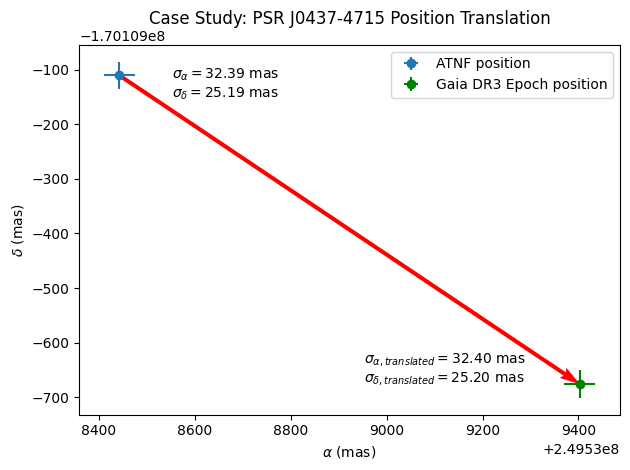

In [47]:
fig = plt.figure(figsize=(6.4, 4.8))
ax1 = fig.add_subplot()

x = np.linspace(psr.ra.to_value(u.mas), psr_dr3.ra.to_value(u.mas) + 10, 10)

ax1.errorbar(psr.ra.to_value(u.mas), psr.dec.to_value(u.mas), yerr= dec_err.to_value(u.mas), xerr= ra_err.to_value(u.mas), fmt= 'o', label= 'ATNF position')
ax1.quiver(psr.ra.to_value(u.mas), psr.dec.to_value(u.mas), prop3ra.value, prop3dec.value, color= 'red', scale = 1, scale_units= 'xy', angles= 'xy')
#ax1.fill_between(x, y1(x), y2(x), alpha = 0.3, color= 'r')
ax1.errorbar(psr_dr3.ra.to_value(u.mas), psr_dr3.dec.to_value(u.mas), yerr= prop_dec_err_dr3.value, xerr= prop_ra_err_dr3.value, fmt= 'go', ecolor= 'green', label= 'Gaia DR3 Epoch position')
#ax.axis([psr.ra.to_value(u.mas)-20, psr.ra.to_value(u.mas) + prop3ra.value + 20, psr.dec.to_value(u.mas) - 20, psr.dec.to_value(u.mas) + prop3dec.value+20])
ax1.legend()
ax1.text(psr.ra.to_value(u.mas)+prop3ra.value-850, psr.dec.to_value(u.mas)-5, r'$\sigma_{\alpha}=32.39$ mas')
ax1.text(psr.ra.to_value(u.mas)+prop3ra.value-850, psr.dec.to_value(u.mas)-40, r'$\sigma_{\delta}=25.19$ mas')
ax1.text(psr.ra.to_value(u.mas)+prop3ra.value-450, psr.dec.to_value(u.mas)-525, r'$\sigma_{\alpha, translated}=32.40$ mas')
ax1.text(psr.ra.to_value(u.mas)+prop3ra.value-450, psr.dec.to_value(u.mas)-560, r'$\sigma_{\delta, translated}=25.20$ mas')
ax1.set_title('Case Study: PSR J0437-4715 Position Translation', pad= 15)
ax1.set_xlabel(r'$\alpha$ (mas)')
ax1.set_ylabel(r'$\delta$ (mas)')

fig.tight_layout()

Optional feature: add a fill between that shows the full region that that the proper motion starts to take up with the errors included

In [ ]:
# define extremes of pm differences:
pm_minus_dec_err = psr.pm_dec - pmdec_err - dec_err.to(u.mas)/u.yr
pm_plus_dec_err = psr.pm_dec + pmdec_err + dec_err.to(u.mas)/u.yr
pm_minus_ra_err = psr.pm_ra_cosdec - pmra_err - ra_err.to(u.mas)/u.yr
pm_plus_ra_err = psr.pm_ra_cosdec + pmra_err + ra_err.to(u.mas)/u.yr

new_m1 = (psr_dr3.dec.to(u.mas) - (pmdec_err * epoch_diff_dr3) - dec_err.to(u.mas) - psr.dec.to(u.mas)).value/(psr_dr3.ra.to(u.mas) + (pmra_err * epoch_diff_dr3) + ra_err.to(u.mas) - psr.ra.to(u.mas)).value
new_m2 = (psr_dr3.dec.to(u.mas) + (pmdec_err * epoch_diff_dr3) + dec_err.to(u.mas) - psr.dec.to(u.mas)).value/(psr_dr3.ra.to(u.mas) - (pmra_err * epoch_diff_dr3) - ra_err.to(u.mas) - psr.ra.to(u.mas)).value
new_b1 = psr.dec.to_value(u.mas) - new_m1*psr.ra.to_value(u.mas)
new_b2 = psr.dec.to_value(u.mas) - new_m2*psr.ra.to_value(u.mas)

# define the functions that will be filled between
#y1 and y2 define new proper motions that include the pm and pos errors
def y1(x):
    return (psr.dec.to_value(u.mas) - (pm_plus_dec_err / pm_minus_ra_err) * psr.ra.to_value(u.mas)) + (pm_plus_dec_err / pm_minus_ra_err) * x

def y2(x):
    return (psr.dec.to_value(u.mas) - (pm_minus_dec_err / pm_plus_ra_err) * psr.ra.to_value(u.mas)) + (pm_minus_dec_err / pm_plus_ra_err) * x
# pm y1 and pm y2 only propagates pm error
def pm_y1(x):
    return new_m1*x + new_b1

def pm_y2(x):
    return new_m2*x + new_b2
